In [1]:
def modplot(e):
    #function to plot modulus of complex vector
    e = np.asarray(e.T)
    plt.plot(modulus(e))
    plt.show()
    
def frameplot(X,movshape):
    #plot a single frame
    fig, axes = plt.subplots()
    axes.imshow(X.reshape(movshape), cmap='Greys')
    axes.set_title('snapshot frame = 1')
    
def modulus(X):
    #function to calculate modulus of complex vector
    modX = np.sqrt(X.real**2 + X.imag**2)
    return modX

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.linalg import svd, inv, eig, pinv

## Part 1 - Load Video

In [3]:
def read_video_gray(name, n_frames):
    cap = cv2.VideoCapture('./{}'.format(name))
    bw_frames = []
    i = 0
    while cap.isOpened() and i < n_frames:
        ret, frame = cap.read()
        arr = np.array(frame)
        # https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/
        # using the weighted method (luminosity method)
        im = (0.299*arr[:,:,0] + 0.587*arr[:,:,1] + 0.114*arr[:,:,2])/255
        im = 1-im
        bw_frames.append(im)
        i += 1
    return np.array(bw_frames)

def read_video_color(name, n_frames):
    cap = cv2.VideoCapture('./{}'.format(name))
    frames = []; bw_frames = []
    i = 0
    while cap.isOpened() and i < n_frames:
        ret, frame = cap.read()
        arr = np.array(frame)
        frames.append(arr)
    return np.array(frames)

In [4]:
#60Hz video, 
#taking 360 frames, 6 seconds of video
f = 3*60
#choose between movies
titles = ['Race','Ski']
mov = read_video_gray(name='monte_carlo.mov',n_frames=f); name = 0 #to indicate figure names
#mov = read_video_gray(name='ski_drop.mov',n_frames=f); name = 1 #to indicate figure names

#get res, number of pixels for monte_carlo.mov
p = mov[0].shape[0] * mov[0].shape[1]
movshape = mov[0].shape

resolution = (1112, 1872) , frames =  180
pixel =  2081664


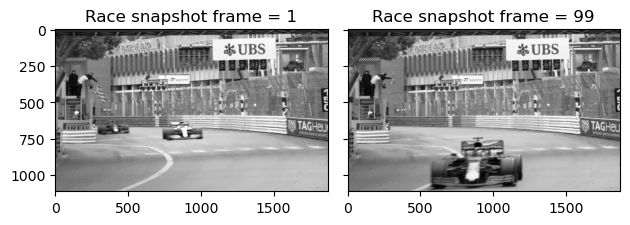

In [5]:
print('resolution =', movshape, ', frames = ', len(mov))
print('pixel = ',p)
fig, axes = plt.subplots(1,2, sharey=True)
axes[0].imshow(mov[0], cmap='Greys')
axes[1].imshow(mov[100], cmap='Greys')
axes[0].set_title('{} snapshot frame = 1'.format(titles[name]))
axes[1].set_title('{} snapshot frame = 99'.format(titles[name]))
fig.tight_layout()
plt.savefig('./figures/{}_snapshots.png'.format(titles[name]), bbox_inches = 'tight', dpi =200)

## Part 2 - Format data for DMD

In [6]:
D = np.empty(shape=(p,f))

for i in range(0,f):
    D[:,i] = mov[i].reshape(-1)

# X has frames {1,...,119}, Y has frames {2,...,120}
X = D[:,0:(f-1)]; Y = D[:,1:f]

print('D', D.shape)
print('X', X.shape, 'Y', Y.shape)

del mov;

D (2081664, 180)
X (2081664, 179) Y (2081664, 179)


## Part 3 - Dynamic Mode Decomposition

$Y = A X \rightarrow A=YX^{\dagger} $  with $X^{\dagger} = (U\Sigma V^*)^{-1}$

Exact DMD [73], $\tilde{A} \in (f,f)$ instead of $A \in (p,p)$

$\tilde{A} = U^* Y V \Sigma^{-1}$


### 1) Exact DMD method, with reduced $\tilde{A}$ matrix

In [7]:
U,S,Vh = svd(X.astype('float64'), full_matrices=False,compute_uv=True)

print('U shape = {}, S shape = {}, V shape = {}'.format(U.shape, np.diag(S).shape, Vh.shape))

U shape = (2081664, 179), S shape = (179, 179), V shape = (179, 179)


In [8]:
B = Y @ Vh.T @ pinv(np.diag(S))
At = np.matmul(U.T,B)

print('A shapes =', At.shape)

A shapes = (179, 179)


### 2) Eigen Decomposition

In [9]:
eigval, eigvec = eig(At); 

print('eigval size = ',eigval.size,', eigvec shape =',eigvec.shape )

zero_real = []; zero_imag = []
for i in range(0,f-1):
    if eigval[i].real == 0.:
        zero_real.append(i)
    elif eigval[i].imag == 0.:
        zero_imag.append(i)
print('zero real', zero_real,'zero imag', zero_imag)

eigval size =  179 , eigvec shape = (179, 179)
zero real [] zero imag [0, 47, 178]


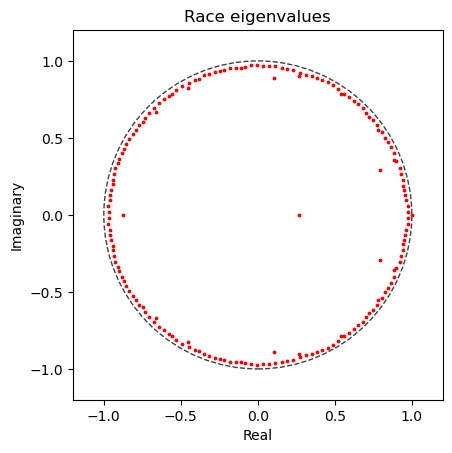

In [10]:
# plot the complex numbers
x = eigval.real; y = eigval.imag

fig, ax = plt.subplots()
c = plt.Circle( (0, 0), 1 , fill = False, linestyle='--',alpha=0.75 )
ax.set_aspect(1)
ax.add_artist(c)
ax.scatter(x, y, s=3, c='red')

ax.set_ylabel('Imaginary')
ax.set_xlabel('Real')

ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_title('{} eigenvalues'.format(titles[name]))
plt.savefig('./figures/{}_eigenvalues.png'.format(titles[name]), bbox_inches = 'tight', dpi =200)



### 3) DMD modes and eigenvalue scaling

DMD modes: $\varphi = U w \in (p,f)$, where $w$ = eigvec of matrix $\tilde{A}$

X reconstruction $X_{\text{DMD}} = \Phi \Omega^n b$, $n \in \{1,2,3...,N\}$

with amplitudes $b = (\Phi^* \Phi)^{-1}\Phi^* X_0$ and $\Omega = Diag(\exp(\omega_m))$

In [11]:
phi = np.matmul(U,eigvec)
#phi = np.matmul(B,eigvec) @ pinv(np.diag(eigval))

phih = np.asmatrix(phi).H

g1 = pinv(np.matmul(phih,phi))
g2 = np.matmul(phih, X[:,0])
b = np.matmul(g1,g2.T)

print('phi shape = {}, b shape = {}'.format(phi.shape, b.shape))
del phih; del g1; del g2

phi shape = (2081664, 179), b shape = (179, 1)


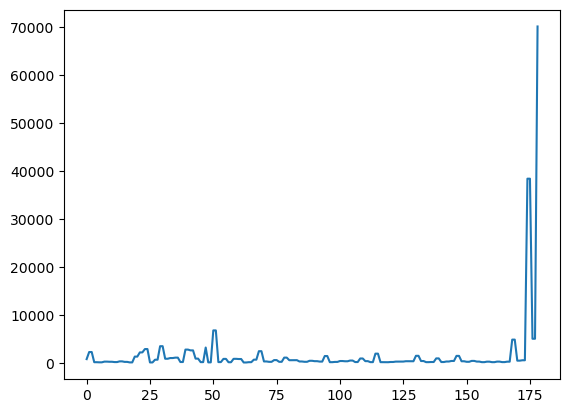

In [12]:
plt.plot(modulus(np.asarray(b)))

### 4) Filtering out small frequencies

background with $||\omega_m|| \approx 0$ or $||\mu_m|| \approx 1$ 

foreground with $||\omega_m|| >>> 0$ or $||\mu_m|| - 1 >>> 0$ 

In [13]:
mu_mod = np.sqrt(eigval.real**2+eigval.imag**2)
l = np.argmin(np.abs(mu_mod - 1))
l

0

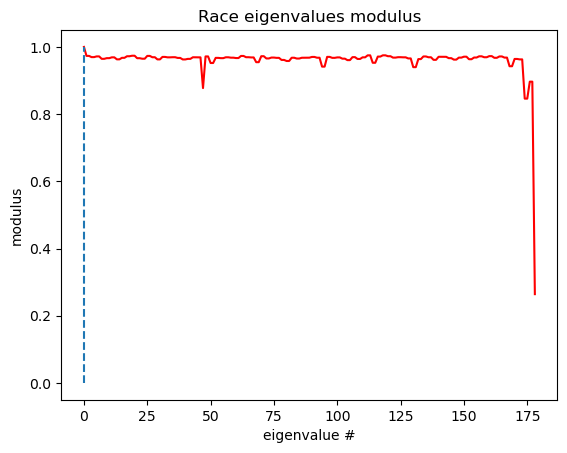

In [14]:
# plot modulus of eigen values
fig, ax = plt.subplots()
ax.plot(mu_mod, c='red')
ax.stem(l, mu_mod[l],markerfmt=' ',linefmt ='--', basefmt= ' ')

ax.set_ylabel('modulus')
ax.set_xlabel('eigenvalue #')
ax.set_title('{} eigenvalues modulus'.format(titles[name]))
plt.savefig('./figures/{}_modulus_eval.png'.format(titles[name]), bbox_inches = 'tight', dpi =200)

### 5) Construct Lowrank

$X = X_{\text{DMD}}^{\text{Low-Rank}} + X_{\text{DMD}}^{\text{Sparse}}$

$X_t = b_p \varphi_p \exp(\omega_p t)$ where $p \in $ null_omega

In [15]:
# Filter background
# phi = (p,f)
# eigvalmat = (f,f)
# b = (f,1)
phi_lr= np.matrix(phi[:,l], dtype = 'complex64');
b_lr = b[l]
eigval_lr = np.matrix(eigval[l].astype('complex64'))

print('phi[l] shape = {}, eigval[l] shape = {}, b[l] shape = {}'.format(phi_lr.shape, eigval_lr.shape, b_lr.shape))
print('eigval[l] = {}, b[l] = {}'.format(eigval_lr, b_lr))


phi[l] shape = (1, 2081664), eigval[l] shape = (1, 1), b[l] shape = (1, 1)
eigval[l] = [[1.0000546+0.j]], b[l] = [[777.00048873+2.77354754e-11j]]


In [16]:
X_lowrank = np.empty((p,f), dtype ='complex64')
for t in range(0,f):
    Xl = eigval_lr**t * b_lr * phi_lr
    X_lowrank[:,t] = Xl

X_lowrank_modulus = modulus(X_lowrank)

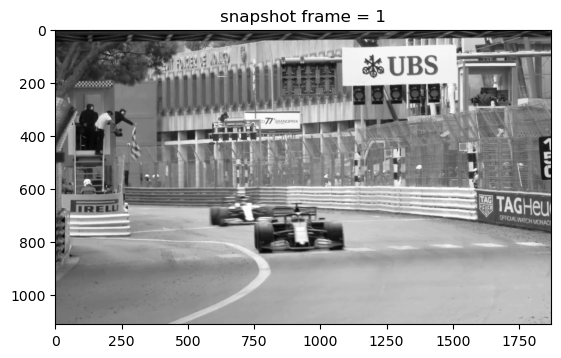

In [17]:
frameplot(X_lowrank_modulus[:,105], movshape)

### 6) Sparse matrix construction

$X_{\text{DMD}}^{\text{Sparse}} = X - |X_{\text{DMD}}^{\text{Lowrank}}| $


In [18]:
#sparse matrix
X_sparse = D-X_lowrank_modulus; del X_lowrank_modulus;

### 7) Residual Correction
$X_{\text{DMD}}^{\text{Sparse}} \leftarrow  X_{\text{DMD}}^{\text{Sparse}} + R$

$X_{\text{DMD}}^{\text{Lowrank}} \leftarrow X_{\text{DMD}}^{\text{Lowrank}} - R$

In [19]:
#residual matrix
R = X_sparse.copy()
R[R>0] = 0

#Xf_lowrank = X_lowrank + R

#final video without background
X_sparse_mod = modulus(X_sparse - R)

In [20]:
del R; del X_sparse;

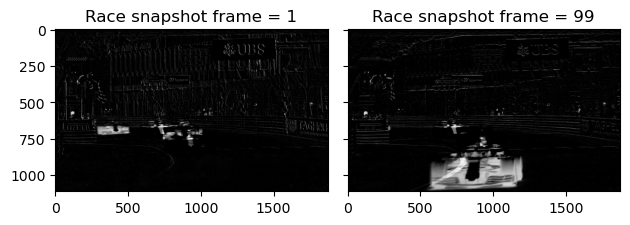

In [21]:
fig, axes = plt.subplots(1,2, sharey=True)
axes[0].imshow(1-X_sparse_mod[:,0].reshape(movshape), cmap='Greys')
axes[1].imshow(1-X_sparse_mod[:,99].reshape(movshape), cmap='Greys')
axes[0].set_title('{} snapshot frame = 1'.format(titles[name]))
axes[1].set_title('{} snapshot frame = 99'.format(titles[name]))
fig.tight_layout()
plt.savefig('./figures/{}_foreground.png'.format(titles[name]), bbox_inches = 'tight', dpi =200)

## Part 5 - Save video

In [23]:
duration = 3
fps = 60
out = cv2.VideoWriter('{}_foreground.mp4'.format(titles[name]), cv2.VideoWriter_fourcc(*'mp4v'), 
                      fps, (movshape[1], movshape[0]), False)
for t in range(fps * duration):
    invbw = X_sparse_mod[:,t].reshape(movshape)
    frame = 255*invbw
    data = frame.astype('uint8')
    out.write(data)
out.release()